# Quick Overview

DataSet: HR Analytics: Job Change of Data Scientists

Quick summary: A data company that wants to predict whether people are willing to job change or not. They have different features that can help with predicting the job change.

Features:

enrollee_id : Unique ID for candidate
city: City code
city_ development _index : Developement index of the city (scaled)
gender: Gender of candidate
relevent_experience: Relevant experience of candidate
enrolled_university: Type of University course enrolled if any
education_level: Education level of candidate
major_discipline :Education major discipline of candidate
experience: Candidate total experience in years
company_size: No of employees in current employer's company
company_type : Type of current employer
last_new_job: Difference in years between previous job and current job
training_hours: training hours completed
target: 0 – Not looking for job change, 1 – Looking for a job change
Inspiration:

Predict the probability of a candidate will work for the company
Interpret model(s) such a way that illustrate which features affect candidate decision

# Importing Libraries & Dataset

In [ ]:
# # Install Package
# !pip install catboost
# !pip install lime
# !pip install shap
# !pip install gradio
# !pip install streamlit

In [2]:
# general libraries
import copy
import time
import warnings
import numpy as np
import pandas as pd
import pickle
import copy
from tqdm.notebook import tqdm
from collections import Counter
# warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import graphviz
from sklearn.tree import export_graphviz

# Outlier detection
import scipy.stats as stats
from sklearn.ensemble import IsolationForest

# modelling
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Pipeline
from imblearn.pipeline import Pipeline, make_pipeline

# evaluation metric
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score)

# Resampling
from sklearn.utils import resample
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling  import ADASYN, SMOTE, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, SMOTENC, SMOTEN
from imblearn.under_sampling import NearMiss, TomekLinks, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN
from imblearn.combine        import SMOTETomek, SMOTEENN

# interpretability
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

# Model deployment
# import gradio as gr
from flask import Flask
import streamlit as st

#Extra
import joblib

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
## Loading Dataset
hr = pd.read_csv('aug_train.csv')
print(hr.shape)
hr.head()

(19158, 14)


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


# Data Checking

In [4]:
hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [5]:
hr.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [8]:
# Cheking of null values per column
hr.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

Majority of candidates in the talent pool are NOT actively seeking for a job. This gives us an imbalanced dataset

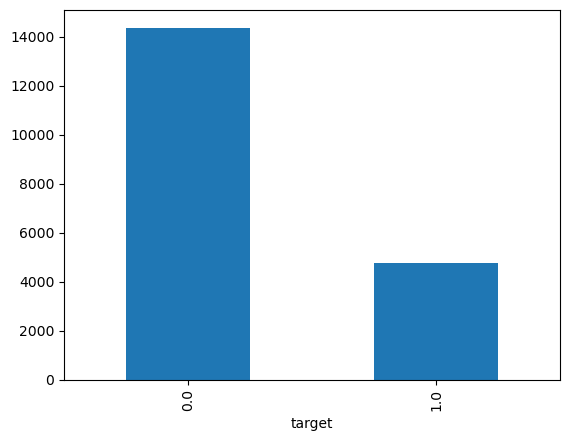

In [13]:
target_dist = hr['target'].value_counts()
target_dist.plot(kind='bar')
plt.show()

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


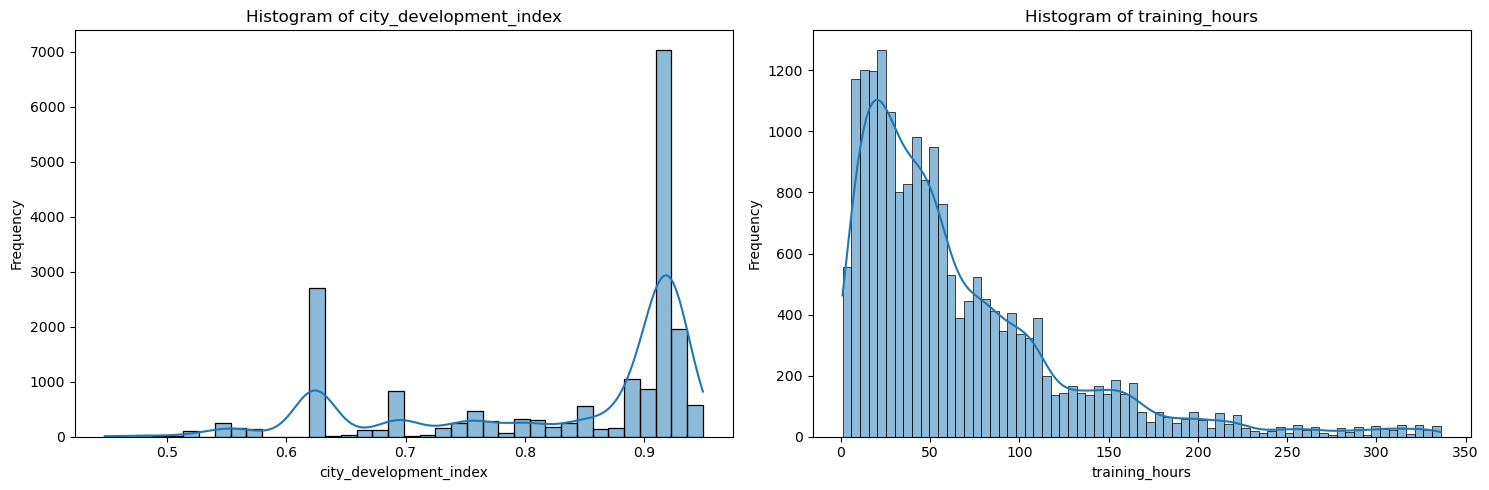

In [11]:
# Creating a histogram for num cols
num_cols = ['city_development_index', 'training_hours', 'target']

# Set up subplots
plt.figure(figsize=(15, 5))

# Plot histogram for 'city_development_index'
plt.subplot(1, 2, 1)
sns.histplot(hr['city_development_index'], kde=True)
plt.title('Histogram of city_development_index')
plt.xlabel('city_development_index')
plt.ylabel('Frequency')

# Plot histogram for 'training_hours'
plt.subplot(1, 2, 2)
sns.histplot(hr['training_hours'], kde=True)
plt.title('Histogram of training_hours')
plt.xlabel('training_hours')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Categorical Columns Test & Check

In [ ]:
# Add corr_matrix for categorical cols

In [24]:
hr['city'].unique()

array(['city_103', 'city_40', 'city_21', 'city_115', 'city_162',
       'city_176', 'city_160', 'city_46', 'city_61', 'city_114',
       'city_13', 'city_159', 'city_102', 'city_67', 'city_100',
       'city_16', 'city_71', 'city_104', 'city_64', 'city_101', 'city_83',
       'city_105', 'city_73', 'city_75', 'city_41', 'city_11', 'city_93',
       'city_90', 'city_36', 'city_20', 'city_57', 'city_152', 'city_19',
       'city_65', 'city_74', 'city_173', 'city_136', 'city_98', 'city_97',
       'city_50', 'city_138', 'city_82', 'city_157', 'city_89',
       'city_150', 'city_70', 'city_175', 'city_94', 'city_28', 'city_59',
       'city_165', 'city_145', 'city_142', 'city_26', 'city_12',
       'city_37', 'city_43', 'city_116', 'city_23', 'city_99', 'city_149',
       'city_10', 'city_45', 'city_80', 'city_128', 'city_158',
       'city_123', 'city_7', 'city_72', 'city_106', 'city_143', 'city_78',
       'city_109', 'city_24', 'city_134', 'city_48', 'city_144',
       'city_91', 'city_

In [18]:
hr['city'].nunique()

123

In [19]:
hr['gender'].value_counts()

gender
Male      13221
Female     1238
Other       191
Name: count, dtype: int64

In [21]:
hr['relevent_experience'].value_counts()

relevent_experience
Has relevent experience    13792
No relevent experience      5366
Name: count, dtype: int64

In [22]:
hr['enrolled_university'].value_counts()

enrolled_university
no_enrollment       13817
Full time course     3757
Part time course     1198
Name: count, dtype: int64

In [23]:
hr['education_level'].value_counts()

education_level
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: count, dtype: int64

In [35]:
hr['company_type'].value_counts()

company_type
Pvt Ltd                9817
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: count, dtype: int64

In [36]:
hr['last_new_job'].value_counts()

last_new_job
1        8040
>4       3290
2        2900
never    2452
4        1029
3        1024
Name: count, dtype: int64

# Data Cleaning

## Dropping Columns

1. Dropped identifier column: enrollee_id
2. Dropped city because we cannot cross reference the codes with any geographical areas
3. Dropped company_size because it has a lot of nulls and is a hassle to impute. We can also just estimate the size of the company using the company_type

In [53]:
# Creating the cross_table
cross_table = pd.crosstab(index=hr_drop['company_type'], columns=hr_drop['company_size'])

# Get the average and sort in descending order
cross_table['average_count'] = cross_table.mean(axis=1)
cross_table = cross_table.sort_values('average_count', ascending=False)

# Display the resulting DataFrame
cross_table

company_size,10/49,100-500,1000-4999,10000+,50-99,500-999,5000-9999,<10,average_count
company_type,,,,,,,,,
Pvt Ltd,910,1833,1016,1739,2151,622,412,728,1176.375
Funded Startup,193,214,0,0,390,54,0,144,124.375
Public Sector,43,151,165,150,116,87,79,35,103.250
Early Stage Startup,176,27,0,0,109,2,0,286,75.000
NGO,32,174,73,37,77,37,29,36,61.875
Other,12,20,15,16,18,11,7,14,14.125


In [64]:
# Drop unecessary and identifer vars
to_drop = ['enrollee_id', 'city', 'company_size'] # no data for city_code, dropped
hr_drop = hr.drop(columns=to_drop)

In [65]:
hr_drop.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_type,last_new_job,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,1,36,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,Pvt Ltd,>4,47,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,never,83,0.0
3,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,Pvt Ltd,never,52,1.0
4,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,Funded Startup,4,8,0.0


In [66]:
hr_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  19158 non-null  float64
 1   gender                  14650 non-null  object 
 2   relevent_experience     19158 non-null  object 
 3   enrolled_university     18772 non-null  object 
 4   education_level         18698 non-null  object 
 5   major_discipline        16345 non-null  object 
 6   experience              19093 non-null  object 
 7   company_type            13018 non-null  object 
 8   last_new_job            18735 non-null  object 
 9   training_hours          19158 non-null  int64  
 10  target                  19158 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.6+ MB


## Adjusting Data Types

Interestingly, there are two columns related to experience: 
- relevent_experience: binary (will be One_Hot encoded)
- experience: string because of less than and greater than. Removed greater and less than

last_new_job also has the same issues with experience, so we will also adjust.

In [67]:
# Adjust experience
hr_drop['experience'] = hr_drop['experience'].str.replace('>','')
hr_drop['experience'] = hr_drop['experience'].str.replace('<','')
hr_drop['experience'] = pd.to_numeric(hr_drop['experience'])

In [68]:
# Adjust last_new_job
hr_drop['last_new_job'] = hr_drop['last_new_job'].str.replace('>','')
hr_drop['last_new_job'] = hr_drop['last_new_job'].str.replace('<','')
hr_drop['last_new_job'] = hr_drop['last_new_job'].str.replace('never','0')

hr_drop['last_new_job'] = pd.to_numeric(hr_drop['last_new_job'])

In [69]:
hr_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  19158 non-null  float64
 1   gender                  14650 non-null  object 
 2   relevent_experience     19158 non-null  object 
 3   enrolled_university     18772 non-null  object 
 4   education_level         18698 non-null  object 
 5   major_discipline        16345 non-null  object 
 6   experience              19093 non-null  float64
 7   company_type            13018 non-null  object 
 8   last_new_job            18735 non-null  float64
 9   training_hours          19158 non-null  int64  
 10  target                  19158 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 1.6+ MB


## Dealing with Null Values

We decided to:
1. Impute the MODE for categorical columns
2. Impute the MEDIAN for numerical columns

In [70]:
hr_drop.shape

(19158, 11)

In [71]:
hr_drop.isna().sum().sort_values(ascending=False)

company_type              6140
gender                    4508
major_discipline          2813
education_level            460
last_new_job               423
enrolled_university        386
experience                  65
city_development_index       0
relevent_experience          0
training_hours               0
target                       0
dtype: int64

In [72]:
# Getting mode of all categorical columns with null values for imputation
mdisc_mode = hr_drop['major_discipline'].mode()[0]
company_type_mode = hr_drop['company_type'].mode()[0]
gender_mode = hr_drop['gender'].mode()[0]
enrolled_university_mode = hr_drop['enrolled_university'].mode()[0]
education_level_mode = hr_drop['education_level'].mode()[0]

print('major discipline mode: ', mdisc_mode)
print('company type mode: ', company_type_mode)
print('gender mode: ', gender_mode)
print('enrolled university mode: ', enrolled_university_mode)
print('education level mode: ', education_level_mode)

major discipline mode:  STEM
company type mode:  Pvt Ltd
gender mode:  Male
enrolled university mode:  no_enrollment
education level mode:  Graduate


In [73]:
# Getting MEDIAN of all numerical columns with null values for imputation
exp_median = hr_drop['experience'].median()
last_new_job_median = hr_drop['last_new_job'].median()

print('experience median: ', exp_median)
print('last_new_job median: ', last_new_job_median)

experience median:  9.0
last_new_job median:  1.0


In [74]:
# Fill null columns with imputed values

hr_drop['gender'].fillna(gender_mode, inplace = True)
hr_drop['enrolled_university'].fillna(enrolled_university_mode, inplace = True)
hr_drop['education_level'].fillna(education_level_mode, inplace = True)
hr_drop['major_discipline'].fillna(mdisc_mode, inplace = True)
hr_drop['experience'].fillna(exp_median, inplace = True)
hr_drop['company_type'].fillna(company_type_mode, inplace = True)
hr_drop['last_new_job'].fillna(last_new_job_median, inplace = True)

In [75]:
# Create new df
hr_cleaned = hr_drop.copy()

In [76]:
# Check for nulls
hr_cleaned.isna().sum()

city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [77]:
hr_cleaned.shape

(19158, 11)

# Data Preparation

One of the key model preparation techniques is checking for outliers. Having them can really negatively affect the outcome of our model. In this project, we're exploring three techniques:

1. Z-score
2. Isolation Forest
3. Local Outlier Factor (LOF)

In [79]:
hr_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  19158 non-null  float64
 1   gender                  19158 non-null  object 
 2   relevent_experience     19158 non-null  object 
 3   enrolled_university     19158 non-null  object 
 4   education_level         19158 non-null  object 
 5   major_discipline        19158 non-null  object 
 6   experience              19158 non-null  float64
 7   company_type            19158 non-null  object 
 8   last_new_job            19158 non-null  float64
 9   training_hours          19158 non-null  int64  
 10  target                  19158 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 1.6+ MB


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categ

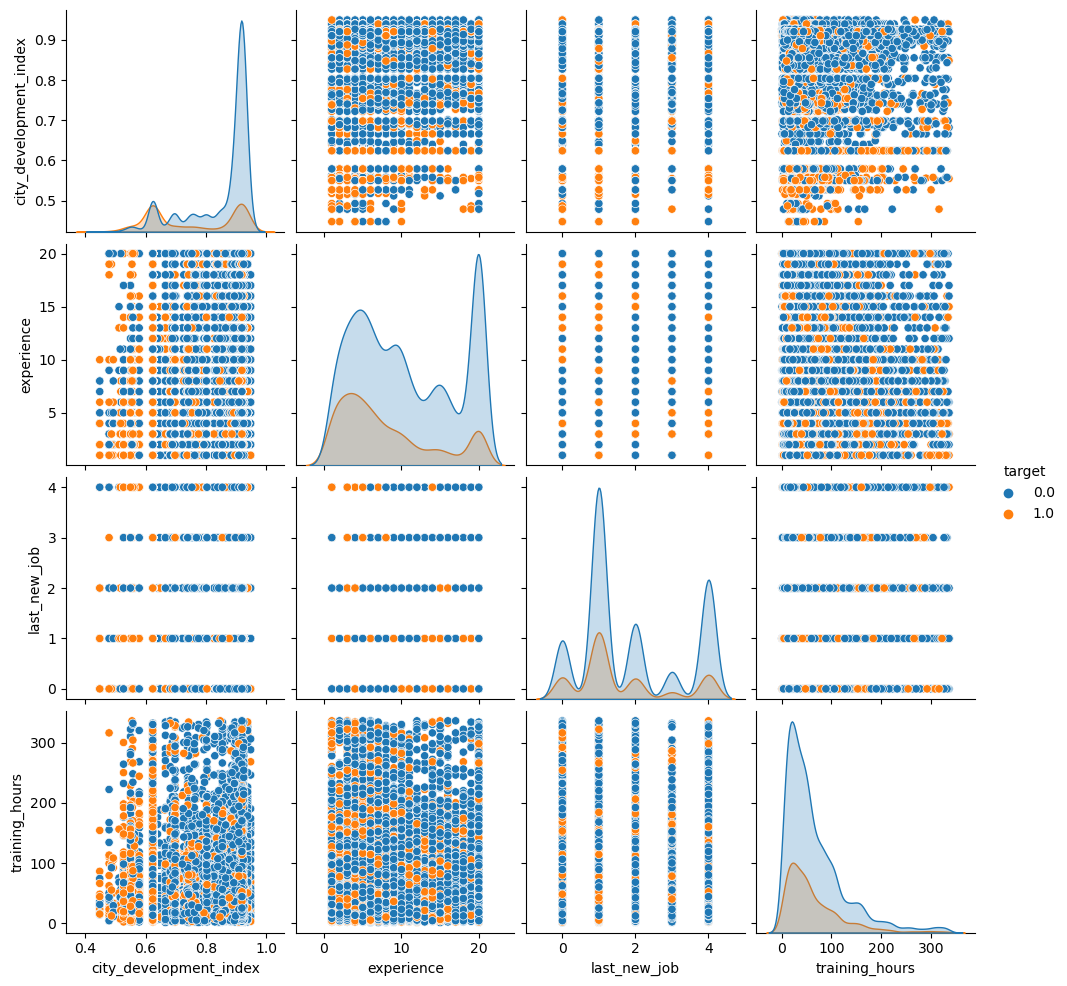

In [80]:
# Checking pairplot of numerical cols
numerical_cols = ['city_development_index', 'experience', 'last_new_job', 'training_hours', 'target']
hr_outlier = hr_cleaned[numerical_cols]
sns.pairplot(hr_outlier, hue='target')
plt.show()

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


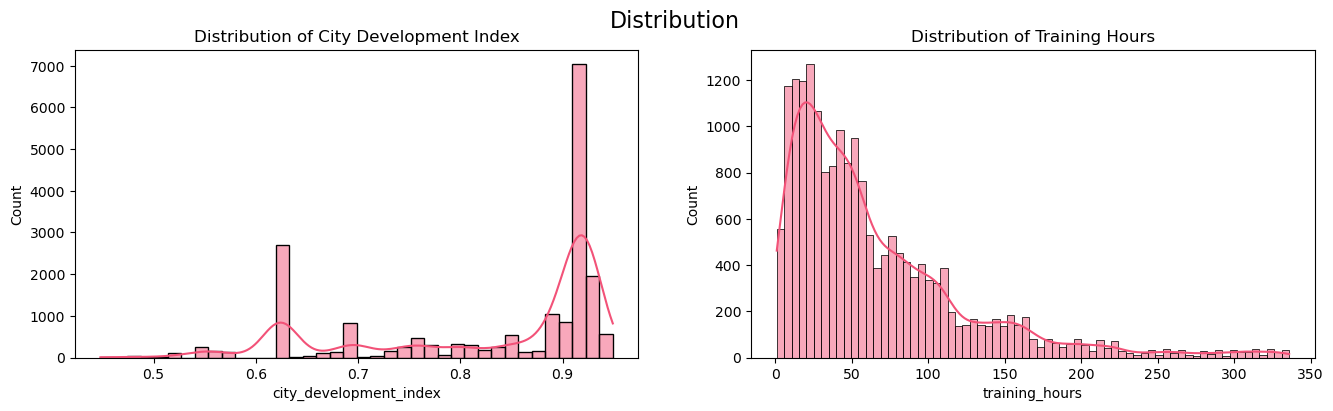

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))
fig.suptitle('Distribution', fontsize=16)

# experience distribution plot
sns.histplot(hr_cleaned["city_development_index"], ax=ax[0], color="#F25278", kde=True)
ax[0].set_title('Distribution of City Development Index')

# training hours distribution plot
sns.histplot(hr_cleaned["training_hours"], ax=ax[1], color="#F25278", kde=True)
ax[1].set_title('Distribution of Training Hours')
plt.show()

## A. Using Z-Score

In [85]:
# getting outliers for training hours
hr_outlier['training_hours_zscore'] = stats.zscore(hr_outlier['training_hours'])
hr_outlier['training_hours_zscore'] = hr_outlier['training_hours_zscore'].apply(lambda x: abs(x))
hr_outlier[hr_outlier['training_hours_zscore'] > 3]

# getting outliers for city development_index
hr_outlier['city_development_index_zscore'] = stats.zscore(hr_outlier['city_development_index'])
hr_outlier['city_development_index_zscore'] = hr_outlier['city_development_index_zscore'].apply(lambda x: abs(x))
hr_outlier[hr_outlier['city_development_index_zscore'] > 3]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,city_development_index,experience,last_new_job,training_hours,target,training_hours_zscore,city_development_index_zscore
1523,0.448,10.0,4.0,48,1.0,0.289174,3.087326
4744,0.448,2.0,0.0,43,1.0,0.372428,3.087326
5010,0.448,1.0,0.0,73,1.0,0.127098,3.087326
5265,0.448,5.0,0.0,86,1.0,0.343559,3.087326
5567,0.448,6.0,1.0,18,1.0,0.788700,3.087326
6127,0.448,4.0,4.0,32,1.0,0.555588,3.087326
7724,0.448,7.0,1.0,28,0.0,0.622192,3.087326
7864,0.448,8.0,4.0,74,0.0,0.143749,3.087326
9134,0.448,2.0,1.0,23,1.0,0.705446,3.087326
10401,0.448,5.0,2.0,36,0.0,0.488985,3.087326


## B. Using Isolation Forest

In [86]:
hr_outlier_sub = hr_outlier[['training_hours', 'city_development_index']]

# initialize baseline
iso=IsolationForest(random_state=143)
iso.fit(hr_outlier_sub)

# prediction of outliers is based on contamination level
y_pred_IF = iso.fit_predict(hr_outlier_sub)
IF_scores = iso.score_samples(hr_outlier_sub)

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


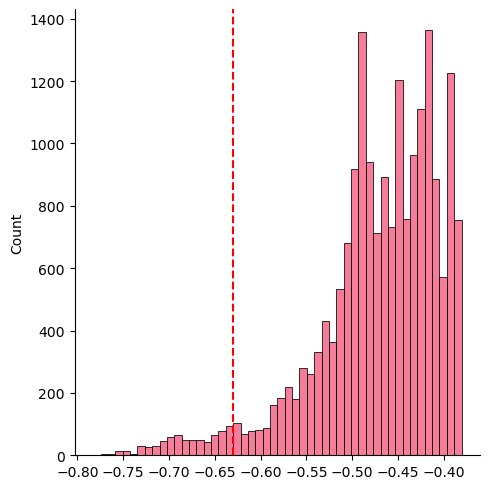

In [87]:
sns.displot(IF_scores, bins=50, color="#F25278")
plt.axvline(-0.63, linestyle='--', color='r')
plt.show()

In [88]:
y_pred_IF = (IF_scores > -0.63) * 2 - 1
hr_outlier['IF_score'] = y_pred_IF
hr_outlier[hr_outlier['IF_score'] == -1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,city_development_index,experience,last_new_job,training_hours,target,training_hours_zscore,city_development_index_zscore,IF_score
69,0.698,2.0,0.0,228,1.0,2.707984,1.060713,-1
89,0.920,6.0,1.0,332,0.0,4.439675,0.738919,-1
119,0.920,10.0,1.0,260,0.0,3.240812,0.738919,-1
133,0.666,20.0,4.0,290,0.0,3.740338,1.320119,-1
161,0.939,20.0,0.0,326,0.0,4.339770,0.892942,-1
...,...,...,...,...,...,...,...,...
19042,0.527,1.0,1.0,19,1.0,0.772050,2.446916,-1
19082,0.558,20.0,1.0,266,1.0,3.340717,2.195616,-1
19100,0.802,4.0,2.0,304,0.0,3.973451,0.217642,-1
19107,0.920,3.0,1.0,322,1.0,4.273166,0.738919,-1


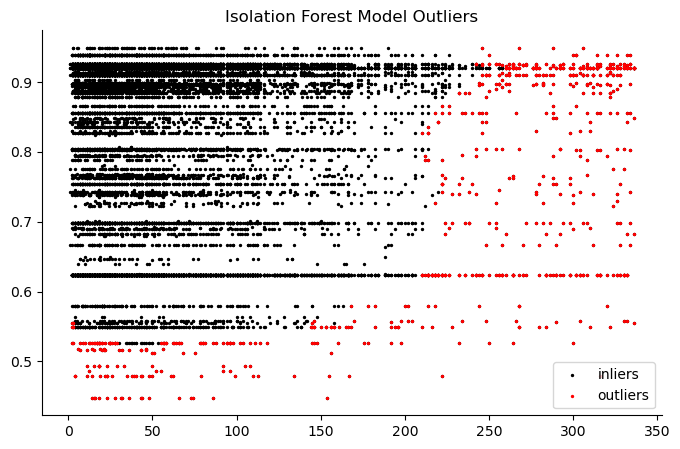

In [89]:
fig, ax = plt.subplots(figsize=(8, 5))

iso_out = hr_outlier[hr_outlier['IF_score'] == -1].index

# Plot data set
ax.scatter(hr_outlier['training_hours'],
           hr_outlier['city_development_index'],
           color='black', label='inliers', s=2.)
ax.scatter(hr_outlier['training_hours'][iso_out],
           hr_outlier['city_development_index'][iso_out],
           color='red', label='outliers', s=2.)
ax.set_title("Isolation Forest Model Outliers")
ax.legend()

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    ax.spines[spine].set_visible(False)

plt.show()

In [90]:
iso_in = hr_outlier[hr_outlier['IF_score'] == 1].index
hr_cleaned_final_iso = hr_cleaned.loc[iso_in].reset_index(drop=True)
hr_cleaned_final_iso.shape
(19158-18432)/19158

0.03789539617914187

In [91]:
# What would the cleaned dataset look like?
hr_cleaned_final_iso.shape

(18432, 11)

## C. Using LOF

In [92]:
from sklearn.neighbors import LocalOutlierFactor

hr_sub = hr_cleaned[['training_hours', 'city_development_index']]

#baseline Local Outlier Factor Model
lof = LocalOutlierFactor()

# prediction of outliers is based on contamination level
y_pred_lof = lof.fit_predict(hr_sub)
lof_scores = lof.negative_outlier_factor_

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


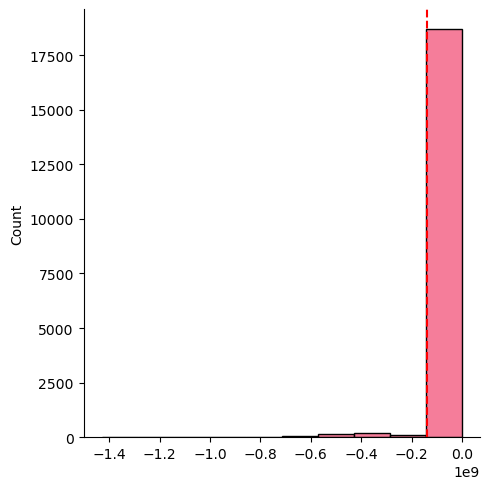

In [93]:
sns.displot(lof_scores, bins=10, color="#F25278")
plt.axvline(-140000000, linestyle='--', color='r')
plt.show()

In [94]:
y_pred_lof = (lof_scores > -140000000) * 2 - 1
hr_sub['LOF_score'] = y_pred_lof
hr_sub[hr_sub['LOF_score'] == -1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,training_hours,city_development_index,LOF_score
74,12,0.550,-1
97,34,0.579,-1
100,24,0.550,-1
205,7,0.550,-1
211,22,0.555,-1
...,...,...,...
18915,21,0.518,-1
18967,4,0.550,-1
19076,28,0.550,-1
19113,53,0.682,-1


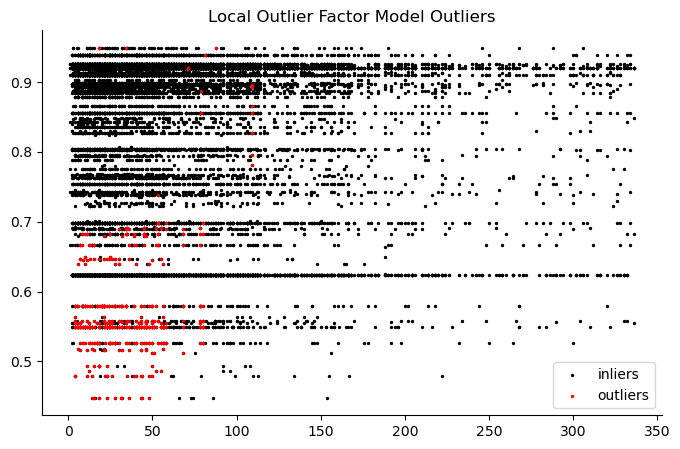

In [95]:
fig, ax = plt.subplots(figsize=(8, 5))

lof_out = hr_sub[hr_sub['LOF_score'] == -1].index

# Plot data set
ax.scatter(hr_sub['training_hours'],
           hr_sub['city_development_index'],
           color='black', label='inliers', s=2.)
ax.scatter(hr_sub['training_hours'][lof_out],
           hr_sub['city_development_index'][lof_out],
           color='red', label='outliers', s=2.)
ax.set_title("Local Outlier Factor Model Outliers")
ax.legend()

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    ax.spines[spine].set_visible(False)

plt.show()

In [96]:
hr_sub

,training_hours,city_development_index,LOF_score
0,36,0.920,1
1,47,0.776,1
2,83,0.624,1
3,52,0.789,1
4,8,0.767,1
...,...,...,...
19153,42,0.878,1
19154,52,0.920,1
19155,44,0.920,1
19156,97,0.802,1


In [97]:
lof_scores = lof.fit_predict(hr_sub)

In [98]:
hr_cleaned['LOF_score'] = lof_scores

In [99]:
# Create a boolean mask to identify outliers (rows with LOF_score equal to -1)
outlier_mask = (hr_cleaned['LOF_score'] == -1)

# Remove rows with outliers from the 'hr_imputed' DataFrame
hr_cleaned_final = hr_cleaned[~outlier_mask]

In [100]:
hr_cleaned_final.drop('LOF_score', axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [101]:
hr_cleaned_final.shape

(14489, 11)

We chose LOF to remove outliers in the cleaned dataset

# One-hot Encode

In [102]:
to_drop3 = []
for col in tqdm(hr_cleaned_final.columns):
    if hr_cleaned_final[col].dtype == 'O': # if the datatype is object
        dummies = pd.get_dummies(hr_cleaned_final[col], prefix=col, drop_first=False)
        hr_cleaned_final = pd.concat([hr_cleaned_final, dummies], axis=1)
        to_drop3.append(col) #append the list
        
hr_cleaned_final = hr_cleaned_final.drop(to_drop3, axis=1)
hr_cleaned_final.head()

  0%|          | 0/11 [00:00<?, ?it/s]

,city_development_index,experience,last_new_job,training_hours,target,gender_Female,gender_Male,gender_Other,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,...,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd
0,0.920,20.0,1.0,36,1.0,False,True,False,True,False,...,False,False,False,True,False,False,False,False,False,True
1,0.776,15.0,4.0,47,0.0,False,True,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,0.624,5.0,0.0,83,0.0,False,True,False,False,True,...,False,False,False,True,False,False,False,False,False,True
3,0.789,1.0,0.0,52,1.0,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,True
4,0.767,20.0,4.0,8,0.0,False,True,False,True,False,...,False,False,False,True,False,True,False,False,False,False


In [103]:
# File post one-hot encoding
hr_cleaned_final.to_csv('hr_df.csv', index=None)

In [104]:
hr_cleaned_final.shape

(14489, 30)

# Exploratory DA

# Modeling

## PCC - Hurdle Rate

Before we even start modeling, we will use PCC to get a baseline. The ultimate question for PCC, is your model performing better than random chance?

Would Recommend:         0
1.0   3966
0.0  10523
Proportion Chance Criterion: 60.24%
1.25 * Proportion Chance Criterion: 75.30%


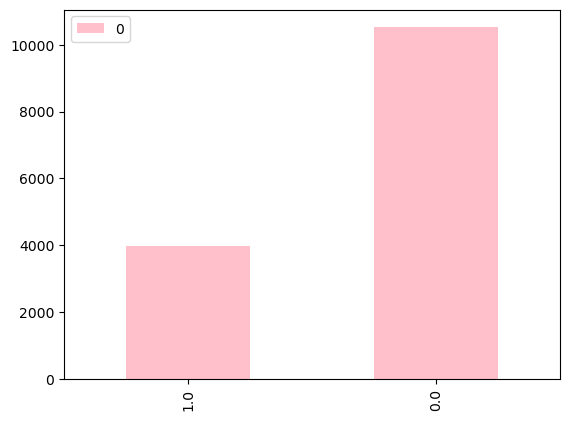

In [105]:
state_counts = Counter(hr_cleaned_final['target']) # Create a data object
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
df_state.plot(kind='bar', color='pink')

num=(df_state[0]/df_state[0].sum())**2

print("Would Recommend:{}".format(df_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

## Choosing the Evaluation Metric

We wil focus on precision evaluation metric, because we want to make sure that most of the predictions are correct to make sure the company will properly allocate most of its resources to active job seekers.

## Creation of Utility Functions

In [106]:
########################################################################
# Class Name  : Resampler
# Description : encapsulate oversampling/undersampling using sklearn.utils.resample
#               to have a method named fit_resample
########################################################################
class Resampler:
    def __init__(self, minority_class_label, majority_class_label, n_samples=0, replace=True, random_state=42):
        self.minority_class_label = minority_class_label
        self.majority_class_label = majority_class_label
        self.n_samples = n_samples
        self.replace = replace
        self.random_state = random_state

    def fit_resample(self, X_train, y_train):
        minority_class = X_train[y_train == self.minority_class_label]
        majority_class = X_train[y_train == self.majority_class_label]

        if self.replace==True:
            # Determine the desired number of samples for oversampling
            self.n_samples = len(majority_class)  # Adjust as needed

            # Oversample the minority class within each fold
            oversampled_minority_class = resample(
                minority_class,
                replace=True,                   # Set to True for oversampling
                n_samples=self.n_samples,
                random_state=self.random_state  # Set a seed for reproducibility
            )

            # Combine the oversampled minority class with the majority class
            X_resampled = np.concatenate([oversampled_minority_class, majority_class], axis=0)
            y_resampled = np.concatenate([np.full(self.n_samples, self.minority_class_label),
                                                np.full(len(majority_class), self.majority_class_label)])

        else:
            # Determine the desired number of samples for undersampling
            self.n_samples = len(minority_class)  # Adjust as needed

            # Undersample the majority class within each fold
            undersampled_majority_class = resample(
                majority_class,
                replace=False,                  # Set to False for undersampling
                n_samples=self.n_samples,
                random_state=self.random_state  # Set a seed for reproducibility
            )

            # Combine the undersampled majority class with the minority class
            X_resampled = np.concatenate([minority_class, undersampled_majority_class], axis=0)
            y_resampled = np.concatenate([np.full(len(minority_class), self.minority_class_label),
                                                np.full(self.n_samples, self.majority_class_label)])

        X_resampled = pd.DataFrame(X_resampled, columns = X_train.columns)
        y_resampled = pd.Series(y_resampled)

        return X_resampled, y_resampled

In [107]:
########################################################################
# Function Name: evaluate_models_features
# Description  : show graph the top features for each models
########################################################################
def evaluate_models_feature(base_models_dict, X_data, y_data):
    models_dict = copy.deepcopy(base_models_dict)
    feature_impt = {}

    # Fit Models
    for model_name, model in tqdm(models_dict.items()):
        model.fit(X_data, y_data)

        if hasattr(model, 'feature_importances_'):
            feature_impt[model_name] = model.feature_importances_

    # Plot Graph
    nrows = int(np.ceil(len(feature_impt) / 2))

    y_val = 1.2
    if nrows > 1: y_val = 0.98

    fig, axis = plt.subplots(nrows=nrows, ncols=2, figsize=(18, 2.3 * nrows))
    fig.suptitle('Feature Importance Analysis', fontsize=16, y=y_val)

    ax = axis.flatten()

    for i, (model_name, feature_impt_list) in enumerate(feature_impt.items()):

        feature_impt_df = (pd.DataFrame({'features': X_data.columns, 'feature_importance': feature_impt_list})
                                .sort_values('feature_importance',ascending=False)[:5])

        feature_impt_df = feature_impt_df[feature_impt_df['feature_importance']>0]
        feature_impt_df = feature_impt_df.sort_values('feature_importance')

        color = ['lightgray'] * len(feature_impt_df)
        color[-1] = '#ff0257'

        ax[i].barh(feature_impt_df.features, feature_impt_df.feature_importance, color=color)
        ax[i].set_title(f'{model_name}',loc='left' )
        ax[i].set_xticks([])

        for spine in ['right', 'top']:
            ax[i].spines[spine].set_visible(False)

        for j, v in enumerate(list(feature_impt_df.feature_importance)):
            ax[i].text(v, j, ' ' + str(round(v,4)), ha='left', va='center', color='black')

    if len(ax) > i:
        for j in range(i+1, len(ax)):
            ax[j].axis('off')

    plt.subplots_adjust(wspace=0.7, hspace=0.25)  # Adjust the value as needed
    plt.show()

In [108]:
########################################################################
# Function Name: auto_ml
# Description  : evaluate ml models
# Parameters   :
#    X          = X_trainval data, Features (input data)
#    y          = y_trainval data, Target data
#    model_dict = dictionary containing model instance
#    scaler     = scaler transformer for data transformation
#    cv         = cross validation
#    res_t      = resampling transformer to address imbalance data
########################################################################
def auto_ml(X, y, models_dict, scaler=None, cv=StratifiedKFold(n_splits=5), res_t=None):
    cmodels_dict = copy.deepcopy(models_dict)
    result = {}

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(cmodels_dict.items()):
        scores = [[],[],[],[],[],[],[],[]]

        #--- Split the training + validation data into K folds and perform cross-validation ---#
        for train_index, val_index in cv.split(X, y): # train and validation set
            X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
            y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]


            #--- Apply Data Transformation ----------------------#
            if scaler != None:
                X_train = scaler.fit_transform(X_train)
                X_val   = scaler.transform(X_val)

            #--- Apply Resampling Technique ----------------------#
            if res_t != None:
                X_train, y_train = res_t.fit_resample(X_train, y_train)

            #--- Fit the train and validation sets ---------------#
            start_time = time.time()    # start logging run times
            model.fit(X_train, y_train)
            end_time = time.time()      # stop logging run times

            #--- Predict the train, validation and hold sets -----#
            train_preds = model.predict(X_train)
            val_preds   = model.predict(X_val)

            #--- Get accuracy, precision, recall, and f1 score ---#
            # accuracy
            scores[0].append(accuracy_score(y_train, train_preds))
            scores[1].append(accuracy_score(y_val, val_preds))

            # precision
            scores[2].append(precision_score(y_train, train_preds))
            scores[3].append(precision_score(y_val, val_preds))

            # recall
            scores[4].append(recall_score(y_train, train_preds))
            scores[5].append(recall_score(y_val, val_preds))

            # f1
            scores[6].append(f1_score(y_train, train_preds))
            scores[7].append(f1_score(y_val, val_preds))
            #-----------------------------------------------------#

        result[model_name] = {
            'train_acc' : np.round(np.mean(scores[0]) * 100, 2),
            'val_acc'   : np.round(np.mean(scores[1]) * 100, 2),
            'train_prec': np.round(np.mean(scores[2]) * 100, 2),
            'val_prec'  : np.round(np.mean(scores[3]) * 100, 2),
            'train_rec' : np.round(np.mean(scores[4]) * 100, 2),
            'val_rec'   : np.round(np.mean(scores[5]) * 100, 2),
            'train_f1'  : np.round(np.mean(scores[6]) * 100, 2),
            'val_f1'    : np.round(np.mean(scores[7]) * 100, 2),
            'run_time'      : end_time - start_time
        }

    # log end time
    total_end = time.time()

    elapsed = total_end - total_start
    print(f"Report Generated in {elapsed:.2f} seconds")

    return pd.DataFrame(result).T

In [109]:
########################################################################
# Function Name: train_model
# Description  : trains ml models across multiple parameters
# Parameters   :
#    X          = X_trainval data, Features (input data)
#    y          = y_trainval data, Target data
#    model_dict = dictionary containing model instance
#    parameters = model parameters
#    metric     = strategy to evaluate the performance of the cross-validated model
#    scaler     = scaler transformer for data transformation
#    cv         = cross validation
#    res_t      = resampling transformer to address imbalance data
#    hypertune  = Flag to hypertune model
#    search_type=
########################################################################
def train_model(X, y, models_dict, metric, parameters=None, scaler=None, cv=StratifiedKFold(n_splits=5), res_t=None, hypertune=False, search_type='random'):
    cmodels_dict = copy.deepcopy(models_dict)
    result = {}

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(cmodels_dict.items()):

        if parameters == None:
            new_params = None
        else:
            new_params = {type(model).__name__.lower() + '__' + key: parameters[model_name][key] for key in parameters[model_name]}

        # Format Pipeline
        imba_pipeline = make_pipeline()

        if scaler != None: imba_pipeline.steps.append((type(scaler).__name__.lower(), scaler))
        if res_t != None:  imba_pipeline.steps.append((type(res_t).__name__.lower(), res_t))
        imba_pipeline.steps.append((type(model).__name__.lower(), model))

        if hypertune:
            if search_type == 'random':
                clf = RandomizedSearchCV(
                    estimator=imba_pipeline,
                    param_distributions=new_params,
                    n_iter=10,                   # Number of random parameter combinations to try
                    scoring=metric,              # Use an appropriate scoring metric
                    cv=cv,                       # Use StratifiedKFold for cross-validation
                    random_state=g_random_state, # Set a random seed for reproducibility
                    return_train_score=True,
                    verbose=-1
                )
            else:
                clf = GridSearchCV(
                    estimator=imba_pipeline,
                    param_grid=new_params,
                    scoring=metric,        # Use an appropriate scoring metric
                    cv=cv,                 # Use StratifiedKFold for cross-validation
                    return_train_score=True,
                    verbose=-1
                )

            start_time = time.time()
            clf.fit(X, y)
            run_time = (time.time() - start_time)

            model = clf.best_estimator_.fit(X, y)


            #--- Save best hyperparameters, best estimator, and best score ---#
            result[model_name] = {
                'train_score'    : np.round(np.mean(clf.cv_results_['mean_train_score']) * 100,2),
                'val_score'      : np.round(clf.best_score_ * 100,2),
                'run_time'       : run_time,
                'best_params'    : clf.best_params_,
                'model'          : model
            }

        else:
            clf = imba_pipeline

            start_time = time.time()
            model = clf.fit(X, y)
            run_time = (time.time() - start_time)

            cv_scores = cross_validate(estimator=model, X=X, y=y,
                                      scoring=metric, cv=cv, n_jobs=-1,
                                      return_train_score=True)

            #--- Save best hyperparameters, best estimator, and best score ---#
            result[model_name] = {
                'train_score'    : np.round(np.mean(cv_scores['train_score']) * 100,2),
                'val_score'      : np.round(np.mean(cv_scores['test_score']) * 100,2),
                'run_time'       : run_time,
                'model'          : model
            }

    # log end time
    total_end = time.time()

    elapsed = total_end - total_start
    print(f"Report Generated in {elapsed:.2f} seconds")

    return pd.DataFrame(result).T

In [110]:
########################################################################
# Function Name: flatten_dict_toframe
# Description  : Flatten dictionary with same values structure
########################################################################
def flatten_dict_toframe(source_dict, key_colname, index_colname):
    source = copy.deepcopy(source_dict)

    # Concatenate the DataFrames and add a new column for dictionary keys
    result_df = pd.concat(source.values(), keys=list(source.keys()))

    # Reset the index and rename the columns if needed
    result_df = result_df.reset_index()
    result_df = result_df.rename(columns={'level_0':key_colname, 'level_1':index_colname})

    return result_df

## A. Baseline Modeling

Baseline modeling basically means keeping as much of the features as possible. This is Step 1 and will be the hurdle for the optimized models

In [112]:
# Split data to features and target
X = hr_cleaned_final.drop(['target'], axis=1) #feature
y = hr_cleaned_final['target']                #target

# Split data to train data and test data
X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(X,     # input data
                                                    y,                 # target
                                                    random_state=1337, # for reproducability
                                                    test_size=0.25,    # portion of the test data
                                                    stratify=y)        # to maintain the number of samples for each class

print('Train/Val Data: feature={} target={}'.format(X_trainval.shape, y_trainval.shape))
print('Holdout Data  : feature={} target={}'.format(X_holdout.shape, y_holdout.shape))

Train/Val Data: feature=(10866, 29) target=(10866,)
Holdout Data  : feature=(3623, 29) target=(3623,)


In [114]:
baseline_models_dict = {
        'KNeighborsClassifier'      : KNeighborsClassifier(), # this is skipped bc of long runtime
        'LogisticRegression'        : LogisticRegression(random_state=1337, max_iter=100000),
        'DecisionTreeClassifier'    : DecisionTreeClassifier(random_state=1337),
        'RandomForestClassifier'    : RandomForestClassifier(random_state=1337),
        'GradientBoostingClassifier': GradientBoostingClassifier(random_state=1337),
        'AdaBoostClassifier'        : AdaBoostClassifier(random_state=1337),
        'ExtraTreesClassifier'      : ExtraTreesClassifier(random_state=1337),
        'XGBClassifier'             : XGBClassifier(random_state=1337),
        'CatBoostClassifier'        : CatBoostClassifier(random_state=1337, verbose=False),
        # 'LGBMClassifier'            : LGBMClassifier(random_state=1337, verbose=-1)
    }


In [115]:
baseline_scores_df = auto_ml(X_trainval, y_trainval, baseline_models_dict)
baseline_scores_df

  0%|          | 0/9 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
# Heatmap of Baseline Metric Results
plt.figure(figsize=(10, 6))
sns.heatmap(baseline_scores_df.iloc[:,:-1], annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Baseline Metric Results")
plt.show()

## B. Standardization of Numerical Cols

In [ ]:
from sklearn.preprocessing import StandardScaler

# Split data to features and target
X = hr_cleaned_final.drop(['target'], axis=1) #feature
y = hr_cleaned_final['target']      #target

# Split data to train data and test data
X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(X,     # input data
                                                    y,                 # target
                                                    random_state=1337, # for reproducability
                                                    test_size=0.25,    # portion of the test data
                                                    stratify=y)        # to maintain the number of samples for each class

print('Train/Val Data: feature={} target={}'.format(X_trainval.shape, y_trainval.shape))
print('Holdout Data  : feature={} target={}'.format(X_holdout.shape, y_holdout.shape))

In [ ]:
standard_scores_df = auto_ml(X_trainval, y_trainval, baseline_models_dict, scaler=StandardScaler())
standard_scores_df

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))

# Model using Best Parameters
sns.heatmap(standard_scores_df.iloc[:, :-1], annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=ax[0])
ax[0].set_title('Baseline Metric Results (Standardize)')

# Baseline Model
sns.heatmap(baseline_scores_df.iloc[:, :-1], annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=ax[1])
ax[1].set_title('Baseline Metric Results')

plt.show()

## C. Addressing Imbalance with Resampling Techniques

In [ ]:
# Split data to features and target
X = hr_cleaned_final.drop(['target'], axis=1) #feature
y = hr_cleaned_final['target']                #target

# Split data to train data and test data
X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(X,     # input data
                                                    y,                 # target
                                                    random_state=1337, # for reproducability
                                                    test_size=0.25,    # portion of the test data
                                                    stratify=y)        # to maintain the number of samples for each class

print('Train/Val Data: feature={} target={}'.format(X_trainval.shape, y_trainval.shape))
print('Holdout Data  : feature={} target={}'.format(X_holdout.shape, y_holdout.shape))

In [ ]:
# Set Global Random State
g_random_state = 1337

# Create a Resampling Dictionary
resampling_dict = {
        'SMOTE'                            : SMOTE(random_state=g_random_state),
        'ADASYN'                           : ADASYN(random_state=g_random_state),
        'BorderlineSMOTE'                  : BorderlineSMOTE(random_state=g_random_state),
        #'SVMSMOTE'                         : SVMSMOTE(random_state=g_random_state),
        #'KMeansSMOTE'                      : KMeansSMOTE(random_state=g_random_state),
        #'SMOTENC'                          : SMOTENC(categorical_features='auto', random_state=g_random_state),
        #'SMOTEN'                           : SMOTEN(random_state=g_random_state),                                   # Run slow
        'NearMiss'                         : NearMiss(),
        'TomekLinks'                       : TomekLinks(),
        'EditedNearestNeighbours'          : EditedNearestNeighbours(),
        'RepeatedEditedNearestNeighbours'  : RepeatedEditedNearestNeighbours(),
        'AllKNN'                           : AllKNN(),
        'SMOTETomek'                       : SMOTETomek(random_state=g_random_state),
        'SMOTEENN'                         : SMOTEENN(random_state=g_random_state),
        'Undersampling'                    : Resampler(minority_class_label=1, majority_class_label=0, replace=False, random_state=g_random_state)  #using sklearn.utils.resample
    }

In [ ]:
# Create the Resampling Result Dictionary
resampling_result_dict = {}

# Run auto ML in every model per each resampling technique
for resampling_name, resampling_instance in resampling_dict.items():
    resampling_result_dict[resampling_name] = auto_ml(X_trainval, y_trainval, baseline_models_dict, res_t=resampling_dict[resampling_name])
    continue

## D. Hypertuning Models